# NumPyro Sample 実行（CV_CNT）

## Libs

In [1]:
import numpyro
import numpyro.distributions as dist

import jax
import arviz as az

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'

import random
import string

In [2]:
jax.devices()

[CpuDevice(id=0)]

# やること
野菜の種の分布をMCMCで作成し、テストパターン別に差を確認する

In [3]:
rng = np.random.default_rng(42)

# 野菜の種
y_A = rng.poisson(lam = 10, size = 50)
y_B = rng.poisson(lam = 11, size = 30)

In [4]:
df_A = pd.DataFrame()
df_B = pd.DataFrame()

df_A['data'] = y_A
df_A['group'] = 'A'

df_B['data'] = y_B
df_B['group'] = 'B'

df = pd.concat([df_A, df_B]).reset_index(drop = True)

In [5]:
df

,data,group
0,13,A
1,6,A
2,9,A
3,11,A
4,9,A
...,...,...
75,6,B
76,13,B
77,8,B
78,13,B


array([[<Axes: title={'center': '0'}>]], dtype=object)

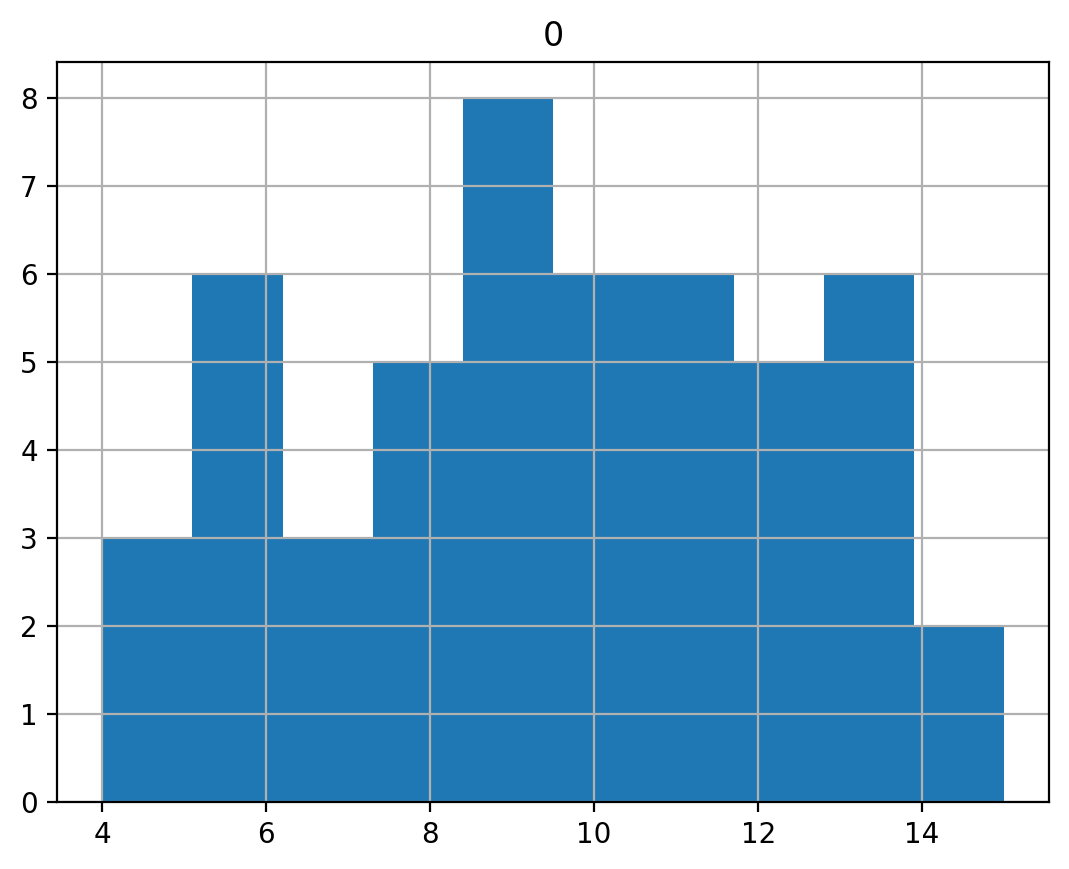

In [6]:
pd.DataFrame(y_A).hist(bins = 10)

## Model 定義

In [6]:
def model(y = None, num_data = 0):

    # パラメーターの事前分布
    mu = numpyro.sample('mu', dist.HalfNormal(10))

    # 観測データ（Y）に基づく尤度の定義
    with numpyro.plate('data', num_data):
        
        numpyro.sample('obs', dist.Poisson(mu), obs = y)

## 推論

In [7]:
nuts = numpyro.infer.NUTS(model)
mcmc = numpyro.infer.MCMC(nuts, num_warmup = 500, num_samples = 3000, num_chains = 4)
mcmc.run(jax.random.PRNGKey(42), y = y, num_data = len(y))
mcmc_samples = mcmc.get_samples()

/var/folders/03/smvv0jp54c5cnt0xtqz_1gkc0000gn/T/ipykernel_22639/2570005247.py:2: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = numpyro.infer.MCMC(nuts, num_warmup = 500, num_samples = 3000, num_chains = 4)
sample: 100%|█| 3500/3500 [00:00<00:00,
sample: 100%|█| 3500/3500 [00:00<00:00,
sample: 100%|█| 3500/3500 [00:00<00:00,
sample: 100%|█| 3500/3500 [00:00<00:00,


## 分析準備

In [8]:
# InferenceData オブジェクトへの変換（az のフォーマットに変換してあげるだけ）
idata = az.from_numpyro(mcmc)

## 収束チェック

array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>]],
      dtype=object)

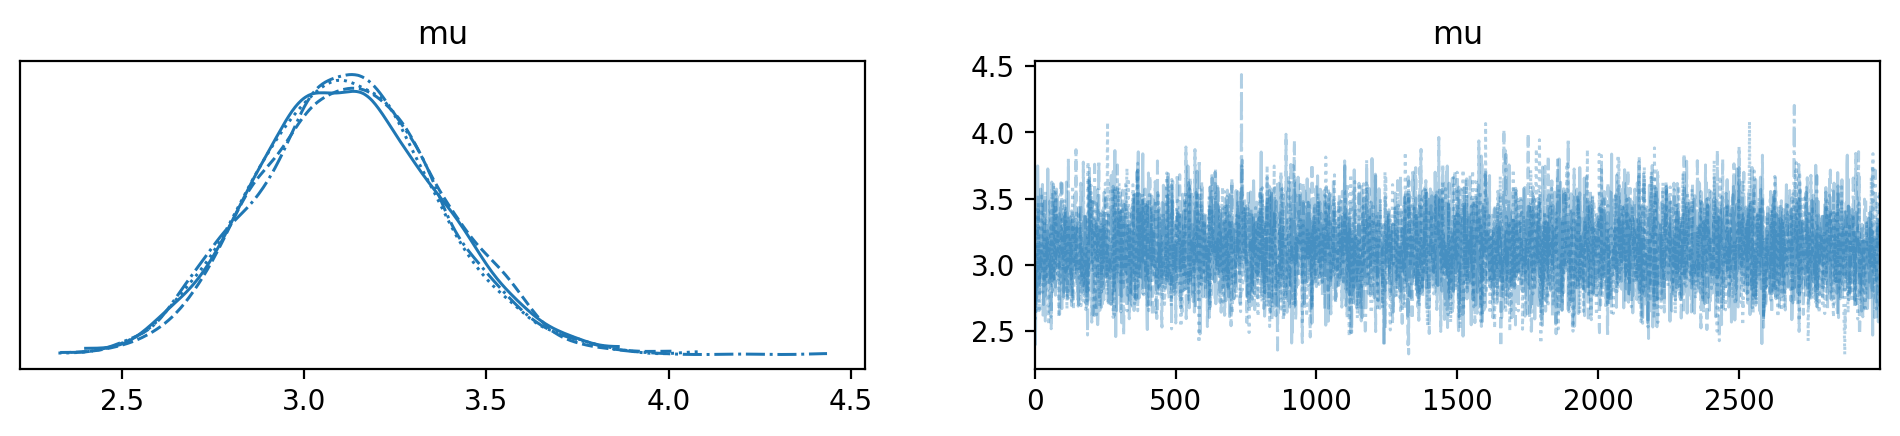

In [9]:
az.plot_trace(idata)

In [10]:
# 基本的には R hat が 1.1未満ならOK
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,3.119,0.249,2.652,3.578,0.004,0.003,4457.0,6354.0,1.0


<Axes: title={'center': 'mu'}>

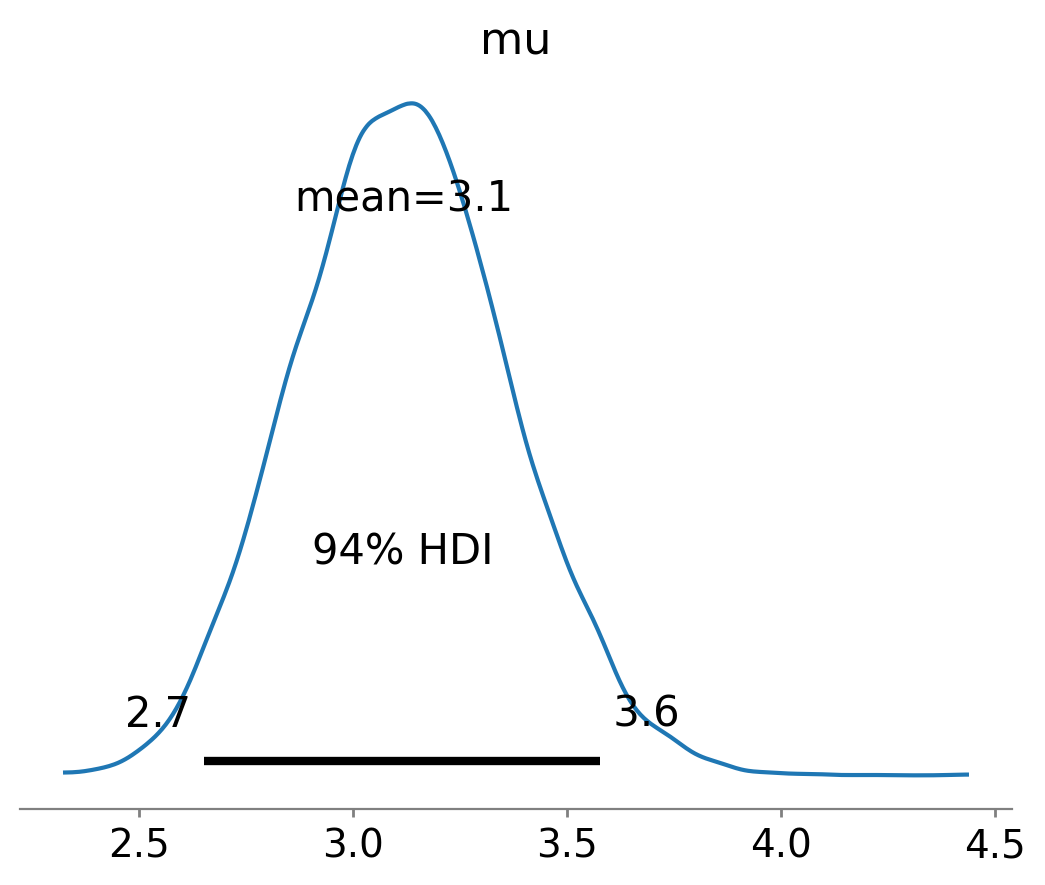

In [11]:
# 基本的には HDI をチェック（Highest Density Interval 最高密度区間 の略）実際にMCMCサンプリングした94%がここに入ってるよていう話
az.plot_posterior(idata)

## 事後予測チェック（PPC：Post Predictive Check）
model がちゃんと真のパラメーターを説明できているかどうか

In [12]:
%%time
#CPU times: user 8min 10s, sys: 2min 37s, total: 10min 47s
#Wall time: 6min 45s

predictive = numpyro.infer.Predictive(model, mcmc_samples) # 事後予測チェックは mcmc_samples を引数に入れて predictive を生成する
ppc_samples = predictive(jax.random.PRNGKey(42), num_data = len(y))

CPU times: user 649 ms, sys: 15.2 ms, total: 664 ms
Wall time: 654 ms


In [13]:
idata_ppc = az.from_numpyro(mcmc, posterior_predictive = ppc_samples)

In [14]:
ppc_mean = ppc_samples['obs'].mean(axis = 1)
ppc_var = ppc_samples['obs'].var(axis = 1)

+ 仮想実験で出てくる大量にサンプリングした結果から得られた平均値分布は青色
+ 実際のデータから得られた平均値は赤色
+ → モデル（青色）の質が良ければ最頻値あたりに実際のデータ（赤色）がきて欲しい

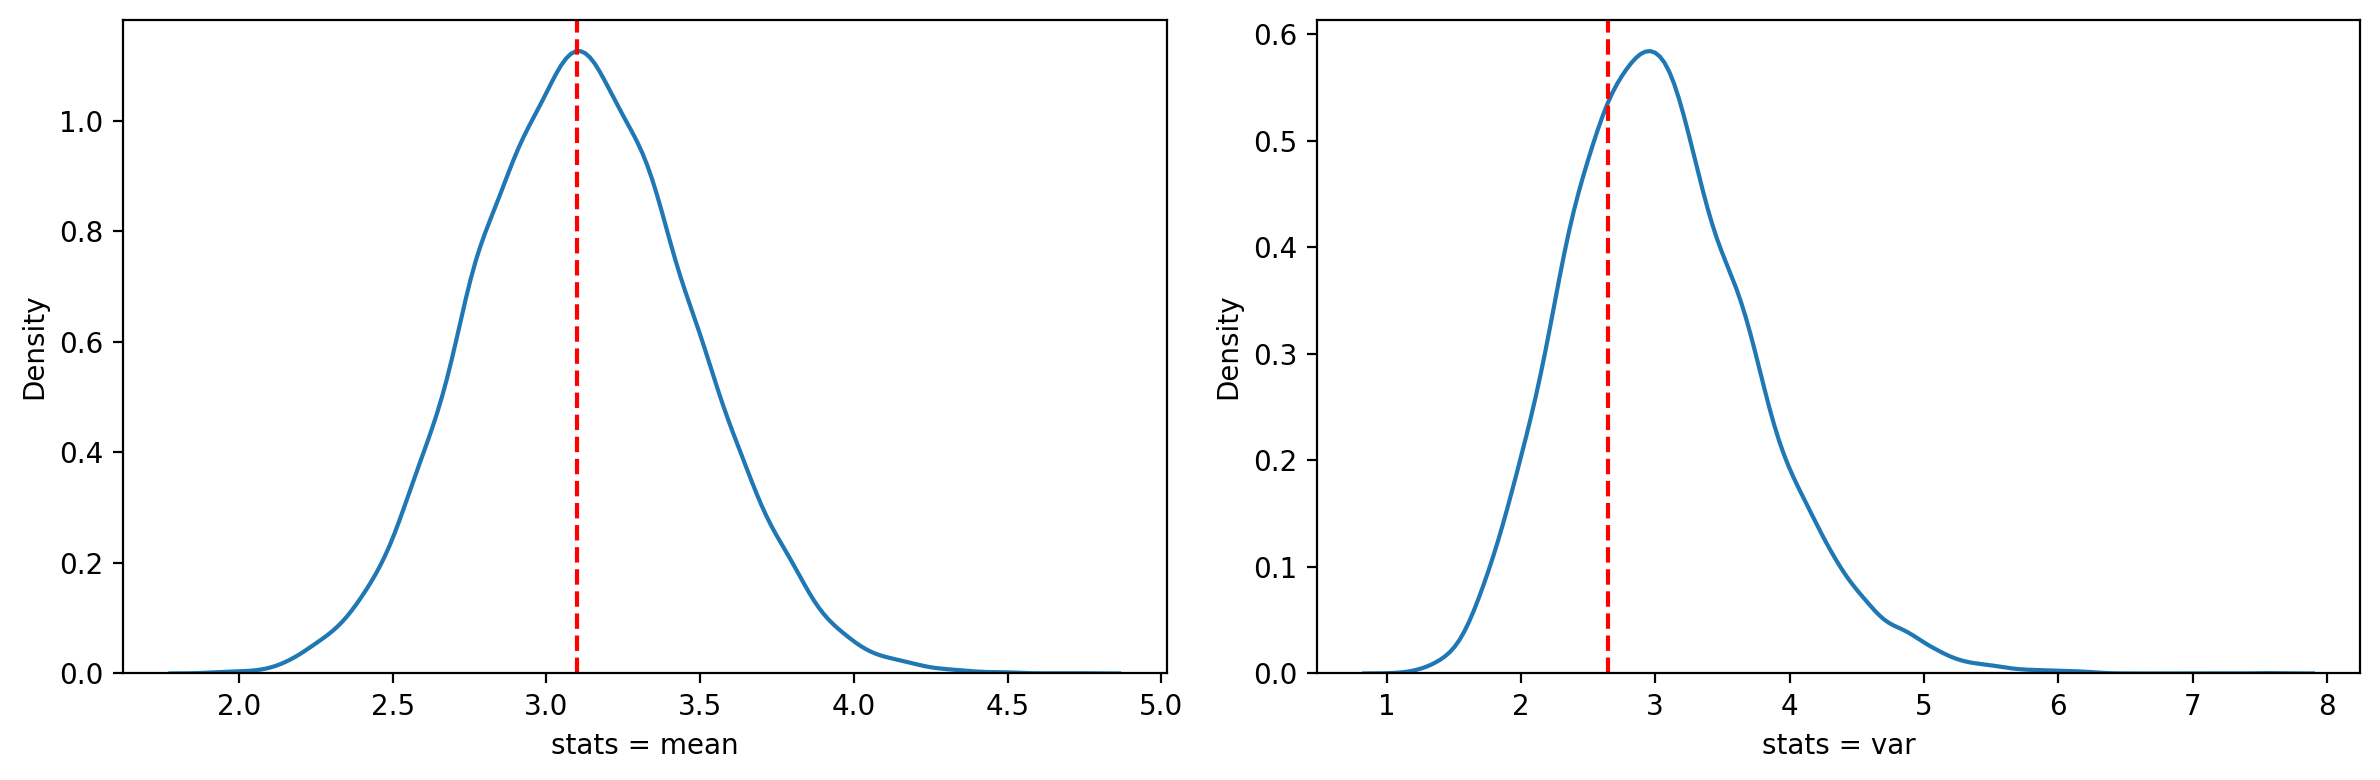

In [15]:
fig, axes = plt.subplots(1, 2, figsize = (12, 4))

sns.kdeplot(ppc_mean, ax = axes[0])
axes[0].axvline(y.mean(), color = 'r', linestyle = 'dashed')
axes[0].set_xlabel('stats = mean')

sns.kdeplot(ppc_var, ax = axes[1])
axes[1].axvline(y.var(), color = 'r', linestyle = 'dashed')
axes[1].set_xlabel('stats = var')

plt.tight_layout()

In [16]:
idata_ppc

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

+ 記述統計量（平均値）ではなく、ヒストグラムを書いた時
+ 何千回とできる仮想実験から得られたヒストグラムは青色（全体平均にするとオレンジ色の点線）
+ 実際に取れたデータのヒストグラムは黒色で出す
+ これが一致すればそんなにおかしなことは起こってないが、もし他の仮想実験から大分外れたものが出てきたとすると、「ちょっとモデルがおかしいんじゃない？」という話になる

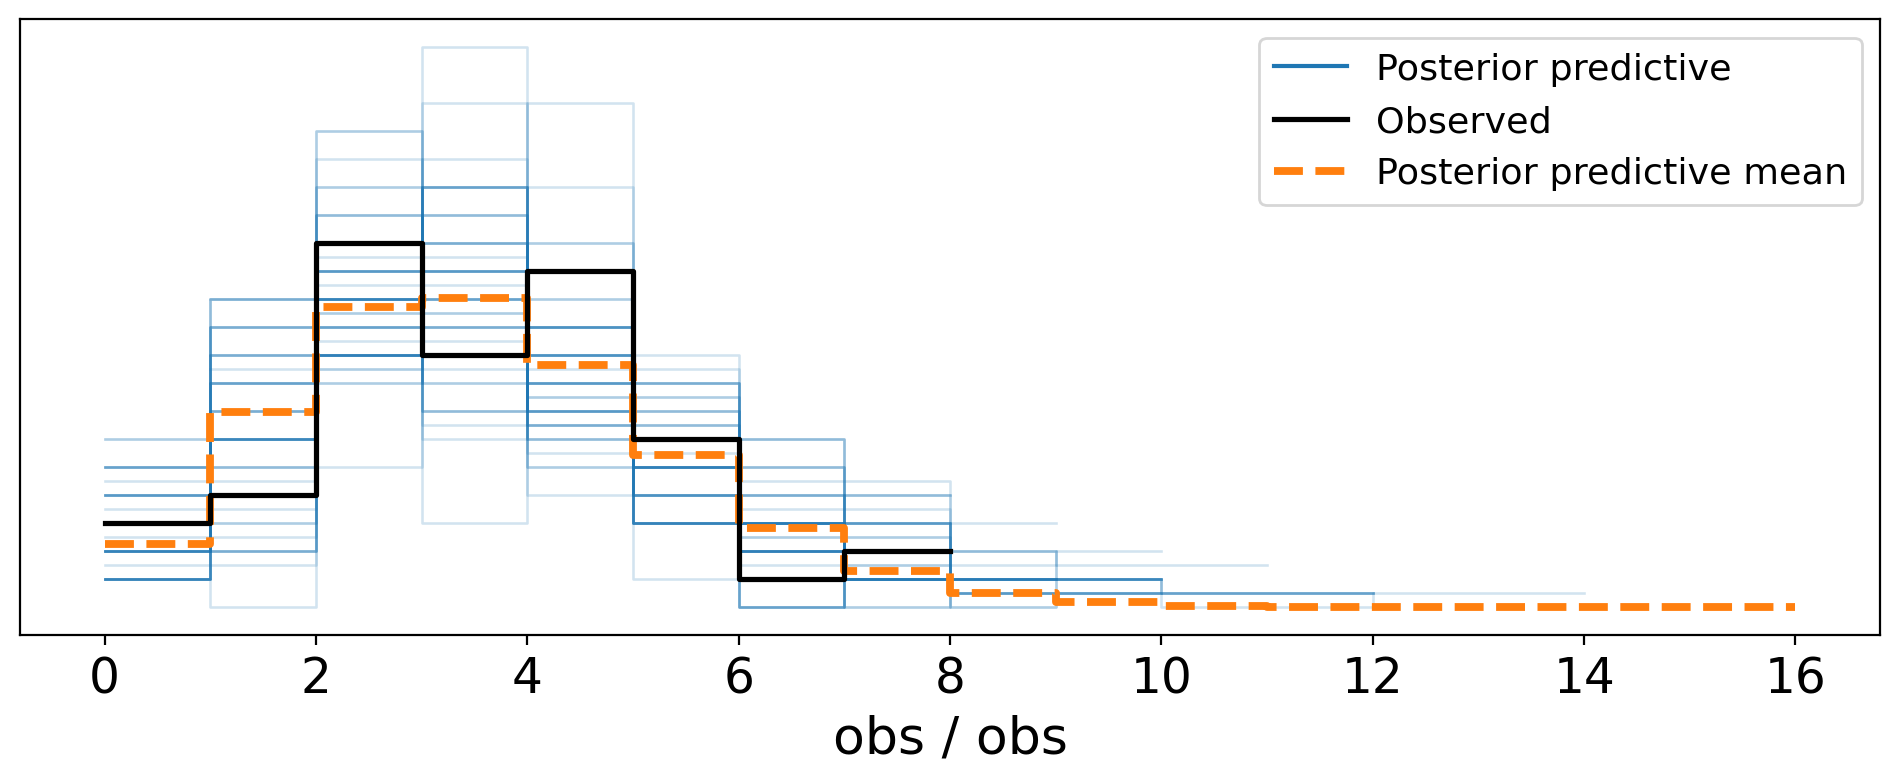

In [17]:
az.plot_ppc(idata_ppc, kind = 'kde', num_pp_samples = 50, figsize = (12,4));

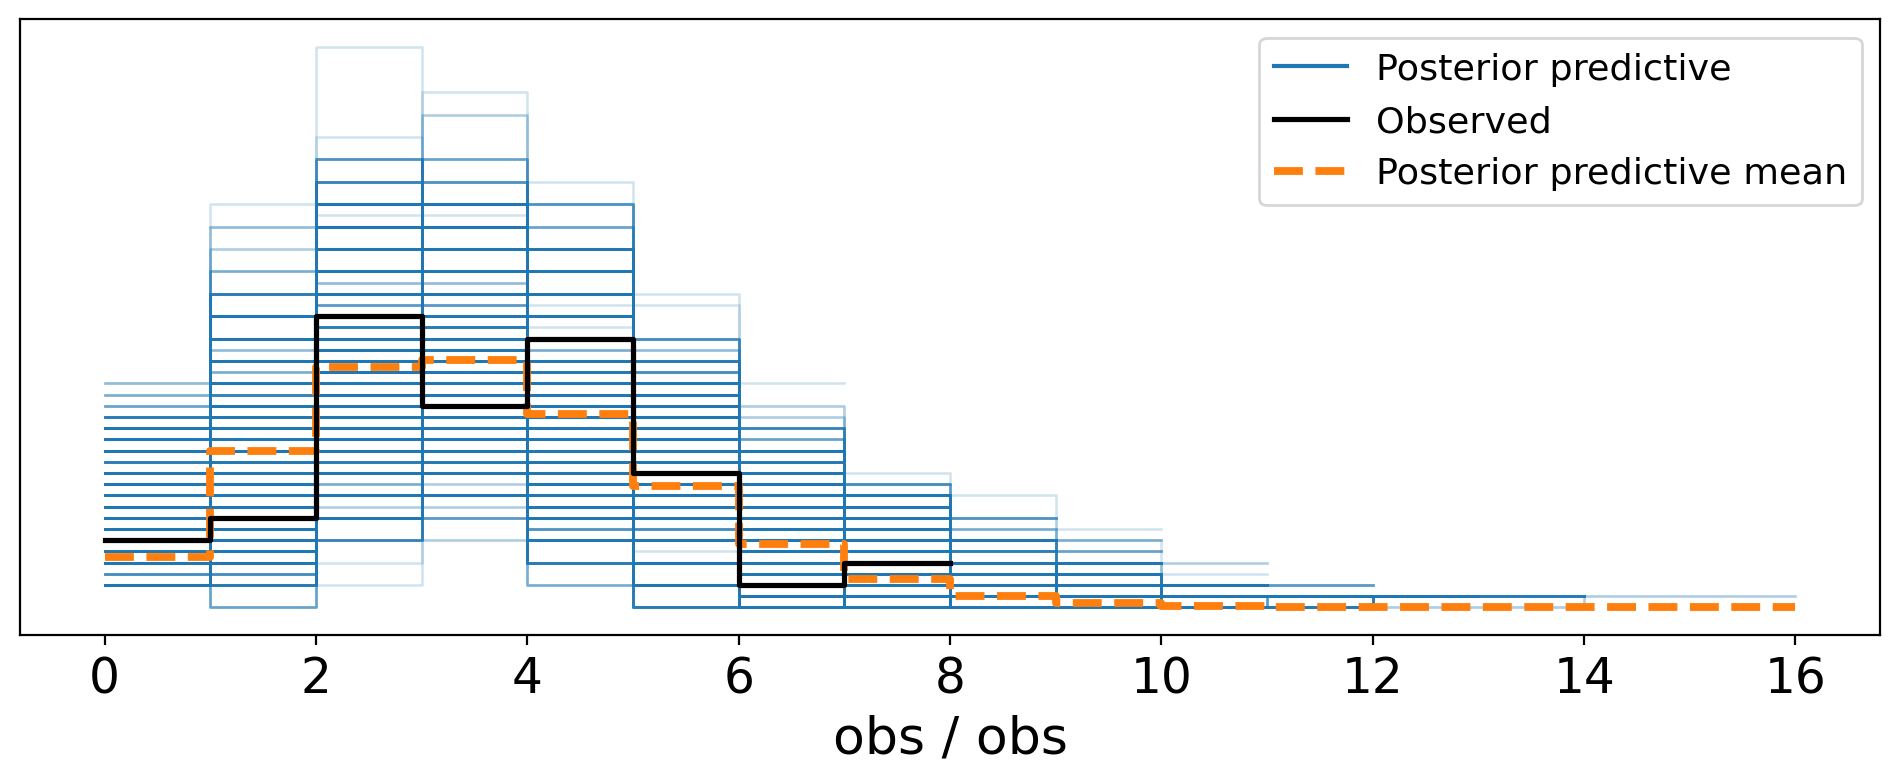

In [18]:
az.plot_ppc(idata_ppc, kind = 'kde', num_pp_samples = 3000, figsize = (12,4));